In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 10)

In [2]:
def create_dataframe(traning_df):
    features_df = traning_df.drop(['Gross PI Premium'],axis=1)
    
    integer_encoding_system = {'Source System':{'Simple':0,'Custom':1}}
    features_df.replace(integer_encoding_system,inplace=True)
    
    features_df['Product'] = features_df['Product'].astype('category')
    features_df['Product_cat'] = features_df['Product'].cat.codes
    features_df.drop(['Product'],axis=1,inplace=True)
    
    features_df['Transaction Type'] = features_df['Transaction Type'].replace('New Business','New business')
    features_df['Transaction Type'] = features_df['Transaction Type'].astype('category')
    features_df['Transaction_Type_Cat'] = features_df['Transaction Type'].cat.codes
    features_df.drop(['Transaction Type'],axis=1,inplace=True)
    
    features_df.rename(mapper={'Clerical EE':'Clerical_EE',
                              'Source System' : 'Source_System', 
                            'Underwriting Year': 'Underwriting_Year',
                            'Public Liability Limit' : 'Public_Liability_Limit', 
                            'Employers Liability Limit': 'Employers_Liability_Limit',
                            'Tools Sum Insured': 'Tools_Sum_Insured',
                            'Professional Indemnity Limit' : 'Professional_Indemnity_Limit',
                            'Contract Works Sum Insured': 'Contract_Works_Sum_Insured',
                            'Hired in Plan Sum Insured' : 'Hired_in_Plan_Sum_Insured',
                            'Own Plant Sum Insured': 'Own_Plant_Sum_Insured', 
                            'Manual EE' : 'Manual_EE', 
                            'Subcontractor EE' : 'Subcontractor_EE',
                            'Trade 1 Risk Level' : 'Trade_1_Risk_Level', 
                            'Trade 2 Risk Level' : 'Trade_2_Risk_Level', 
                            'Commission Amount' : 'Commission_Amount'},axis=1,inplace=True)

    return features_df

In [3]:
traning_df = pd.read_csv(r'C:\Users\rohishah\Desktop\DLAB\First_set.csv')

In [4]:
traning_df = traning_df.reindex(np.random.permutation(traning_df.index))

In [5]:
selected_col_df = create_dataframe(traning_df)

selected_col_df.head()

selected_col_df.columns

In [6]:
# 'Commission Amount' removed from feature dur to log normalization issue
selected_features = ['Source_System', 'Underwriting_Year',
       'Public_Liability_Limit', 'Employers_Liability_Limit',
       'Tools_Sum_Insured', 'Professional_Indemnity_Limit',
       'Contract_Works_Sum_Insured', 'Hired_in_Plan_Sum_Insured',
       'Own_Plant_Sum_Insured', 'Manual_EE', 'Clerical_EE', 'Subcontractor_EE',
       'Trade_1_Risk_Level', 'Trade_2_Risk_Level',
       'DurationofPolicy', 'CombinedTradeRiskLevel',
       'Public_Liability_Limit_1000000', 'Public_Liability_Limit_1000000.1',
       'Public_Liability_Limit_2000000', 'Public_Liability_Limit_5000000',
        'Public_Liability_Limit_5000000.1', 'Public_Liability_Limit_1000000.2',
       'Public_Liability_Limit_1000000.3', 'Employers_Liability_Limit_1000',
       'Professional_Indemnity_Limit_5', 'Professional_Indemnity_Limit_5.1',
       'Professional_Indemnity_Limit_1', 'Professional_Indemnity_Limit_1.1',
       'Professional_Indemnity_Limit_2', 'Professional_Indemnity_Limit_2.1',
       'Professional_Indemnity_Limit_5.2', 'Professional_Indemnity_Limit_5.3',
       'Professional_Indemnity_Limit_1.2', 'Professional_Indemnity_Limit_1.3',
       'Professional_Indemnity_Limit_2.2', 'Professional_Indemnity_Limit_2.3',
       'Tools_Sum_Insured_Ind', 'Contract_Works_Sum_Insured_Ind',
       'Hired_in_Plan_Sum_Insured_Ind', 'Own_Plant_Sum_Insured_Ind',
       'Public_Liability_Limit_5000000.2', 'Public_Liability_Limit_5000000.3',
       'Professional_Indemnity_Limit_g', 'TotalEmployees', 'Product_cat',
       'Transaction_Type_Cat']
selected_target = ['Target1']

In [7]:
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 50
pd.options.display.float_format = '{:.1f}'.format

In [8]:
def preprocess_features(Stores_data_frame):
    selected_featur = Stores_data_frame[selected_features]
    processed_features = selected_featur.copy()
     # Create a synthetic feature.
    return processed_features

In [9]:
def preprocess_targets(Stores_data_frame):
    output_targets = pd.DataFrame()
    output_targets[target] =Stores_data_frame[target] 
    return output_targets

In [10]:
def construct_feature_columns(input_features):
    return set([tf.feature_column.numeric_column(my_feature)
              for my_feature in input_features])

In [11]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    # Convert pandas data into a dict of np arrays.
    features = {key:np.array(value) for key,value in dict(features).items()}                                            
 
    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    # Shuffle the data, if specified.
    if shuffle:
        ds = ds.shuffle(10000)
    
    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [12]:
def train_linear_classifier_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets,
    my_optimizer,
    hidden_units):
    
    periods = 10
    steps_per_period = steps / periods
  
  # Create a linear classifier object.
    my_optimizer = my_optimizer
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_classifier = tf.estimator.DNNClassifier(
      feature_columns=construct_feature_columns(training_examples),
      optimizer=my_optimizer,
      hidden_units = hidden_units)
   
  
  # Create input functions.
    training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets[selected_target], 
                                          batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets[selected_target], 
                                                  num_epochs=1, 
                                                  shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets[selected_target], 
                                                    num_epochs=1, 
                                                    shuffle=False)
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
    print ("Training model...")
    training_log_losses = []
    validation_log_losses = []
    for period in range (0, periods):
        
        linear_classifier.train(input_fn=training_input_fn,
                                steps=steps_per_period)
       # Take a break and compute predictions.
        
        training_probabilities = linear_classifier.predict(input_fn=predict_training_input_fn)
        training_probabilities = np.array([item['probabilities'] for item in training_probabilities])

        validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
        validation_probabilities = np.array([item['probabilities'] for item in validation_probabilities])

        training_log_loss = metrics.log_loss(training_targets, training_probabilities)
        validation_log_loss = metrics.log_loss(validation_targets, validation_probabilities)
        # Occasionally print the current loss.
        #print(period, training_log_loss)
        # Add the loss metrics from this period to our list.
        training_log_losses.append(training_log_loss)
        validation_log_losses.append(validation_log_loss)
   
    print ("Model training finished.")
    
  
  # Output a graph of loss metrics over periods.
    plt.ylabel("LogLoss")
    plt.xlabel("Periods")
    plt.title("LogLoss vs. Periods")
    plt.tight_layout()
    plt.plot(training_log_losses, label="training")
    plt.plot(validation_log_losses, label="Validation")
    plt.legend()

    return linear_classifier

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
def log_normalize(series):
    return series.apply(lambda x:math.log(x+1.0))

In [15]:
def normalize_log(examples_dataframe):
    processed_features = pd.DataFrame()
    for feature in examples_dataframe:
        processed_features[feature] = log_normalize(examples_dataframe[feature])
    return processed_features

In [16]:
def preprocess_features_log(example_data_frame,all_features):
    all_features = example_data_frame[all_features]
    processed_features = all_features.copy()
     # Create a synthetic feature.
    return processed_features

In [17]:
log_normalize_file =preprocess_features_log(normalize_log(preprocess_features_log(selected_col_df,selected_features)),
                                            selected_features)

In [18]:
training_examples, validation_examples, training_targets, validation_targets = train_test_split(log_normalize_file[selected_features], selected_col_df[selected_target],
                                                    test_size = 0.7, random_state = 1)

validation_probabilities = linear_classifier.predict(input_fn=predict_validation_input_fn)
validation_probabilities = np.array([item['probabilities'][1] for item in validation_probabilities])

false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
    validation_targets, validation_probabilities)
plt.plot(false_positive_rate, true_positive_rate, label="our model")
plt.plot([0, 1], [0, 1], label="random classifier")
_ = plt.legend(loc=2)

In [22]:
def train_model(training_examples,training_targets,validation_examples,validation_targets):
    
    #GradientDescentOptimizer
    print("GradientDescentOptimizer")
    linear_classifier = train_linear_classifier_model(
    learning_rate=0.1,
    steps=500,
    batch_size=5,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets,
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1),
    hidden_units=[50,50])
    
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets[selected_target], 
                                                    num_epochs=1, 
                                                    shuffle=False)
    evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)
    print(evaluation_metrics['auc'])
    print(evaluation_metrics['accuracy'])
    
    # FtrlOptimizer
    print("FtrlOptimizer")
    linear_classifier = train_linear_classifier_model(
    learning_rate=0.01,
    steps=500,
    batch_size=5,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets,
    my_optimizer = tf.train.FtrlOptimizer(learning_rate=0.01,l1_regularization_strength=0.2),
    hidden_units=[50,50])
    
    
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets[selected_target], 
                                                    num_epochs=1, 
                                                    shuffle=False)
    evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)
    print(evaluation_metrics['auc'])
    print(evaluation_metrics['accuracy'])
    
    # AdamOptimizer
    print("AdamOptimizer")
    
    linear_classifier = train_linear_classifier_model(
    learning_rate=0.01,
    steps=500,
    batch_size=10,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets,
    my_optimizer = tf.train.AdamOptimizer(learning_rate=0.01),
    hidden_units=[50,50])
    
    
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets[selected_target], 
                                                    num_epochs=1, 
                                                    shuffle=False)
    evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)
    print(evaluation_metrics['auc'])
    print(evaluation_metrics['accuracy'])
    
    # FtrlOptimizer with L1 and L2 regularization
    
    print("FtrlOptimizer with L1 and L2 regularization")
    
    linear_classifier = train_linear_classifier_model(
    learning_rate=0.01,
    steps=500,
    batch_size=50,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets,
    my_optimizer = tf.train.FtrlOptimizer(learning_rate=0.01,l1_regularization_strength=0.2,l2_regularization_strength=0.2),
    hidden_units=[50,50])
    
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets[selected_target], 
                                                    num_epochs=1, 
                                                    shuffle=False)
    evaluation_metrics = linear_classifier.evaluate(input_fn=predict_validation_input_fn)
    print(evaluation_metrics['auc'])
    print(evaluation_metrics['accuracy'])

    return linear_classifier    

GradientDescentOptimizer
Training model...
Model training finished.
0.572979
0.542857
FtrlOptimizer
Training model...
Model training finished.
0.739848
0.690476
AdamOptimizer
Training model...
Model training finished.
0.743214
0.689583
FtrlOptimizer with L1 and L2 regularization
Training model...
Model training finished.
0.760465
0.696131


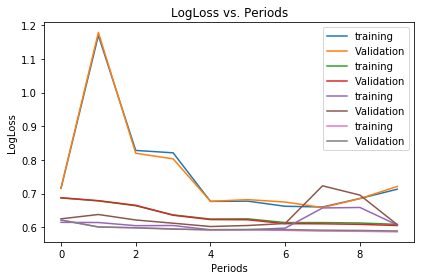

In [23]:
train_model(training_examples,training_targets,validation_examples,validation_targets)

In [24]:
traning_1_df = pd.read_csv(r'C:\Users\rohishah\Desktop\DLAB\First_set1.csv')
traning_1_df = traning_1_df.reindex(np.random.permutation(traning_1_df.index))
selected_col_1_df = create_dataframe(traning_1_df)

In [25]:
log_normalize_file_1 =preprocess_features_log(normalize_log(preprocess_features_log(selected_col_1_df,selected_features)),
                                            selected_features)

In [27]:
training_examples_1, validation_examples_1, training_targets_1, validation_targets_1 = train_test_split(log_normalize_file_1[selected_features], selected_col_1_df[selected_target],
                                                    test_size = 0.7, random_state = 1)

In [31]:
selected_col_1_df.head()

,Target1,Source_System,Underwriting_Year,Public_Liability_Limit,Employers_Liability_Limit,...,Public_Liability_Limit_5000000.3,Professional_Indemnity_Limit_g,TotalEmployees,Product_cat,Transaction_Type_Cat
2273,0,0,2013,1000000,0,...,0,1,1,4,0
1517,0,0,2013,1000000,0,...,0,1,1,4,0
614,0,0,2013,1000000,0,...,0,0,2,2,0
4599,1,0,2013,10000000,10000000,...,1,1,0,4,0
1343,0,0,2013,2000000,0,...,0,0,0,4,0


GradientDescentOptimizer
Training model...
Model training finished.
0.684622
0.66875
FtrlOptimizer
Training model...
Model training finished.
0.734051
0.670833
AdamOptimizer
Training model...
Model training finished.
0.736158
0.680655
FtrlOptimizer with L1 and L2 regularization
Training model...
Model training finished.
0.752757
0.690179


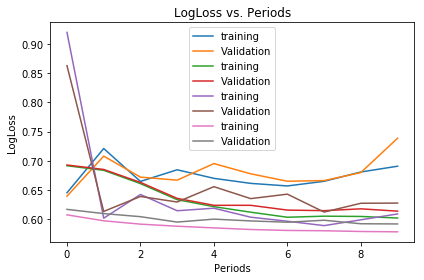

In [32]:
train_model(training_examples_1, training_targets_1,validation_examples_1, validation_targets_1)